In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import csv
import math, time
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os
from pathlib import Path
from tqdm.notebook import tqdm
import multiprocessing

# Check Cuda version
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.0.1+cu118
11.8
False


In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE: {device}')

""" Setting random seed """
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# fix random seed
seed = 2023
same_seeds(seed)

DEVICE: cpu


### ***Load Data***

In [ ]:
cd /content/drive/MyDrive/NLP Class/Model and Dataset

/content/drive/.shortcut-targets-by-id/16qTxxX_m016LbPPJRiQazP4QSb5aCgfO/NLP Class/Model and Dataset


In [ ]:
ls

'onth] BTC.png'
'onth] BTC + Sentiment.png'
'onth] BTC + Sentiment + SP500.png'
'onth] BTC + SP500.png'
'onth] BTC + USD.png'
'onth] BTC + USD + Sentiment.png'
'onth] BTC + USD + Sentiment + SP500.png'
'onth] BTC + USD + SP500.png'
 best_model_cnnlstm_3month.pkl
 best_model_cnnlstm_month.pkl
 best_model_cnnlstm_week.pkl
 best_model_lstm_3month.pkl
 best_model_lstm_month.pkl
 best_model_lstm_week.pkl
 best_model.pkl
 btc_price_3month.ipynb
 btc_price_cnnlstm_3month.ipynb
 btc_price_cnnlstm_month.ipynb
 btc_price_cnnlstm_week.ipynb
 btc_price_lstm_week.ipynb
 btc_price_month.ipynb
'[CNNLSTM 3month] BTC.png'
'[CNNLSTM 3month] BTC + Sentiment.png'
'[CNNLSTM 3month] BTC + Sentiment + SP500.png'
'[CNNLSTM 3month] BTC + SP500.png'
'[CNNLSTM 3month] BTC + USD.png'
'[CNNLSTM 3month] BTC + USD + Sentiment.png'
'[CNNLSTM 3month] BTC + USD + Sentiment + SP500.png'
'[CNNLSTM 3month] BTC + USD + SP500.png'
'[CNNLSTM month] BTC.png'
'[CNNLSTM month] BTC + Sentiment.png'
'[CNNLSTM month] BTC + Sentime

#### **x_month feature**
* 'USD_Open', 'USD_High', 'USD_Low', 'USD_Close', 'USD_Adj Close', 'USD_Volume',
* 'G_Open', 'G_High', 'G_Low', 'G_Close', 'G_Adj Close', 'G_Volume',
* 'Nas_Open', 'Nas_High', 'Nas_Low', 'Nas_Close', 'Nas_Adj Close', 'Nas_Volume',
* 'SP500_Open', 'SP500_High', 'SP500_Low', 'SP500_Close', 'SP500_Adj Close', 'SP500_Volume',
* 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Adj Close', 'BTC_Volume',
* 'Sentiment_average



In [ ]:
def data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32):
  # numpy to tensor
  x_month_tensor = torch.from_numpy(x_month_feature).type(torch.FloatTensor)
  y_month_tensor = torch.from_numpy(y_month_label).type(torch.FloatTensor)
  y_month_tensor = torch.unsqueeze(y_month_tensor, dim=-1)
  print('tensor x shape:', x_month_tensor.shape)
  print('tensor y shape:', y_month_tensor.shape)

  # Split for train and val dataset
  train_x_month, val_x_month, train_y_month, val_y_month = train_test_split(x_month_tensor, y_month_tensor, test_size=test_size, shuffle=False, random_state=2023)
  print('train shape:', train_x_month.shape, train_y_month.shape)
  print('test shape:', val_x_month.shape, val_y_month.shape)

  dataset_train_month = Data.TensorDataset(train_x_month, train_y_month)
  dataset_val_month = Data.TensorDataset(val_x_month, val_y_month)

  loader_train = DataLoader(
      dataset_train_month,
      batch_size=batch_size,
      shuffle = True
  )

  loader_val = DataLoader(
      dataset_val_month,
      batch_size=batch_size,
      shuffle = True
  )

  iterdata_train = next(iter(loader_train))
  print('\ntrain iter:')
  print(iterdata_train[0].shape)
  print(iterdata_train[1].shape)

  iterdata_val = next(iter(loader_val))
  print('\nval iter:')
  print(iterdata_val[0].shape)
  print(iterdata_val[1].shape)
  print('--------------------------------------\n')
  return train_x_month, val_x_month, train_y_month, val_y_month, loader_train, loader_val

In [ ]:
x_month = np.load('x_month.npy', allow_pickle=True)
y_month = np.load('y_month.npy', allow_pickle=True)
print('x shape:', x_month.shape)
print('y shape:', y_month.shape)

x_month = x_month.astype(np.float32)
y_month = y_month.astype(np.float32)

# Split Feature
x_fx_usd = x_month[:, :, :6]
x_fx_sp = x_month[:, :, 12:18]
x_fx_btc = x_month[:, :, 24:30]
x_fx_senti = x_month[:, :, 30:31]
# label: btc low
y_month_label = y_month[:, 3]

# BTC only
x_month_feature = x_fx_btc
train_x_month_1, val_x_month_1, train_y_month_1, val_y_month_1, loader_train_1, loader_val_1 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + USD
x_month_feature = np.concatenate((x_fx_btc, x_fx_usd), axis=2)
train_x_month_2, val_x_month_2, train_y_month_2, val_y_month_2, loader_train_2, loader_val_2 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + Sentiment
x_month_feature = np.concatenate((x_fx_btc, x_fx_senti), axis=2)
train_x_month_3, val_x_month_3, train_y_month_3, val_y_month_3, loader_train_3, loader_val_3 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + USD + Sentiment
x_month_feature = np.concatenate((x_fx_btc, x_fx_usd, x_fx_senti), axis=2)
train_x_month_4, val_x_month_4, train_y_month_4, val_y_month_4, loader_train_4, loader_val_4 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + SP500
x_month_feature = np.concatenate((x_fx_btc, x_fx_sp), axis=2)
train_x_month_5, val_x_month_5, train_y_month_5, val_y_month_5, loader_train_5, loader_val_5 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + USD + SP500
x_month_feature = np.concatenate((x_fx_btc, x_fx_usd, x_fx_sp), axis=2)
train_x_month_6, val_x_month_6, train_y_month_6, val_y_month_6, loader_train_6, loader_val_6 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + Sentiment + SP500
x_month_feature = np.concatenate((x_fx_btc, x_fx_senti, x_fx_sp), axis=2)
train_x_month_7, val_x_month_7, train_y_month_7, val_y_month_7, loader_train_7, loader_val_7 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)

# BTC + USD + Sentiment + SP500
x_month_feature = np.concatenate((x_fx_btc, x_fx_usd, x_fx_senti, x_fx_sp), axis=2)
train_x_month_8, val_x_month_8, train_y_month_8, val_y_month_8, loader_train_8, loader_val_8 = data_process(x_month_feature, y_month_label, test_size=0.2, batch_size=32)


x shape: (1273, 30, 31)
y shape: (1273, 6)
tensor x shape: torch.Size([1273, 30, 6])
tensor y shape: torch.Size([1273, 1])
train shape: torch.Size([1018, 30, 6]) torch.Size([1018, 1])
test shape: torch.Size([255, 30, 6]) torch.Size([255, 1])

train iter:
torch.Size([32, 30, 6])
torch.Size([32, 1])

val iter:
torch.Size([32, 30, 6])
torch.Size([32, 1])
--------------------------------------

tensor x shape: torch.Size([1273, 30, 12])
tensor y shape: torch.Size([1273, 1])
train shape: torch.Size([1018, 30, 12]) torch.Size([1018, 1])
test shape: torch.Size([255, 30, 12]) torch.Size([255, 1])

train iter:
torch.Size([32, 30, 12])
torch.Size([32, 1])

val iter:
torch.Size([32, 30, 12])
torch.Size([32, 1])
--------------------------------------

tensor x shape: torch.Size([1273, 30, 7])
tensor y shape: torch.Size([1273, 1])
train shape: torch.Size([1018, 30, 7]) torch.Size([1018, 1])
test shape: torch.Size([255, 30, 7]) torch.Size([255, 1])

train iter:
torch.Size([32, 30, 7])
torch.Size([32

### ***DL Model***

In [ ]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional=False, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )

        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(hidden_dim, hidden_dim*2, num_layers, batch_first=True, bidirectional=bidirectional)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.conv1(x)
        identity = x
        x = self.conv2(x)
        x = x + identity

        x = x.transpose(1, 2)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim*2).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim*2).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
def initialize_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

In [ ]:
def plot_train_curve(epoch, train_list, valid_list, curve_type, title, fig_size=(12, 10), save_img=False):

  font_size = fig_size[0]

  fig, axes=plt.subplots(1, 1, figsize=fig_size)
  axes.yaxis.set_major_locator(MaxNLocator(12))
  axes.xaxis.set_major_locator(MaxNLocator(10))

  plt.plot(train_list, label='Train', linewidth=1.5)
  plt.plot(valid_list, label='Validation', linewidth=1.5)

  legend_properties = {'size':font_size+4, 'weight':'bold'}
  plt.legend(loc='best', shadow=True, prop=legend_properties)
  plt.grid(alpha=1)
  plt.xlim(0, epoch)
  plt.yticks(fontsize = font_size+4, fontweight='bold')
  plt.xticks(fontsize = font_size+4, fontweight='bold')
  plt.xlabel('Epochs', fontsize=font_size+8, fontweight='bold')
  plt.title(title, fontsize=font_size+10, fontweight='bold')

  if curve_type == 'Accuracy':
    plt.ylabel('Accuracy', fontsize=font_size+8, fontweight='bold')
    plt.ylim(-0.05, 1.05)
  elif curve_type == 'Loss':
    plt.ylabel('Loss', fontsize=font_size+8, fontweight='bold')
    plt.ylim(0, 0.5)
  else:
    raise ValueError('curve_type only is Accuracy or Loss')

  if save_img == True:
    img_name = curve_type + '_' + title + '.png'
    plt.savefig(img_name, bbox_inches='tight')

In [ ]:
def train_val(model, criterion, optimizer, NUM_EPOCHS, loader_train, loader_val):
  loss_train_list = []
  loss_val_list = []

  iteration = 0
  model.apply(initialize_weights)
  lr_epoch = 0.0
  best_loss = 100.0

  tqdm_epoch = tqdm(range(NUM_EPOCHS))

  for epoch in tqdm_epoch:
      if epoch != 0:
          tqdm_epoch.set_postfix({ 'train_loss': loss_train_list[epoch-1], 'val_loss': loss_val_list[epoch-1]})

      train_loss = 0.0
      train_uar_true = []
      train_uar_predict = []
      val_iter_acc = 0.0
      val_loss = 0.0
      val_uar_true = []
      val_uar_predict = []

      """ Training """
      model.train()
      for step, (batch_x, batch_y) in enumerate(loader_train):
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
          optimizer.zero_grad()
          output = model(batch_x)
          loss = criterion(output, batch_y)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          # print('\nall:', train_loss, 'each:', loss.item())

      """ Validation """
      model.eval()
      with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader_val):
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
          val_output = model(batch_x)
          loss = criterion(val_output, batch_y)
          val_loss += loss.item()

      if val_loss < best_loss and epoch>70:
          best_loss = val_loss
          best_epoch = epoch
          torch.save(model.eval(), f'best_model_cnnlstm_month.pkl')
          print(f'\n best epoch {epoch+1}: best loss {val_loss/len(loader_val)}')

      # print('\n:', train_loss, train_acc, test_loss, test_acc)
      loss_train_list.append(train_loss/len(loader_train))
      loss_val_list.append(val_loss/len(loader_val))

  return model, loss_train_list, loss_val_list

In [ ]:
def plot_stock_curve(train_list, valid_list, true_list, title, fig_size=(12, 10), save_img=False):

  font_size = fig_size[0]

  fig, axes=plt.subplots(1, 1, figsize=fig_size)
  axes.yaxis.set_major_locator(MaxNLocator(12))
  axes.xaxis.set_major_locator(MaxNLocator(15))

  date_true = np.arange(len(train_month_predict)+len(valid_list))
  date_train = np.arange(len(train_list))
  date_val = np.arange(len(train_month_predict), len(train_month_predict)+len(valid_list))

  plt.plot(date_true, true_list, label='True', linewidth=2)
  plt.plot(date_train, train_list, label='Train', linewidth=1.5)
  plt.plot(date_val, valid_list, label='Validation', linewidth=1.5)

  legend_properties = {'size':font_size+2, 'weight':'bold'}
  plt.legend(loc='best', shadow=True, prop=legend_properties)
  # plt.grid(alpha=1)
  plt.yticks(fontsize = font_size, fontweight='bold')
  plt.xticks(fontsize = font_size, fontweight='bold')
  plt.xlabel('Date Index', fontsize=font_size+4, fontweight='bold')
  plt.title(title, fontsize=font_size+6, fontweight='bold')
  plt.ylabel('Stock Price Prediction (Normalized)', fontsize=font_size+4, fontweight='bold')

  if save_img == True:
    img_name = title + '.png'
    plt.savefig(img_name, bbox_inches='tight')

### ***BTC***

In [ ]:
input_dim = train_x_month_1.shape[2] # feature
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.033072787104174495


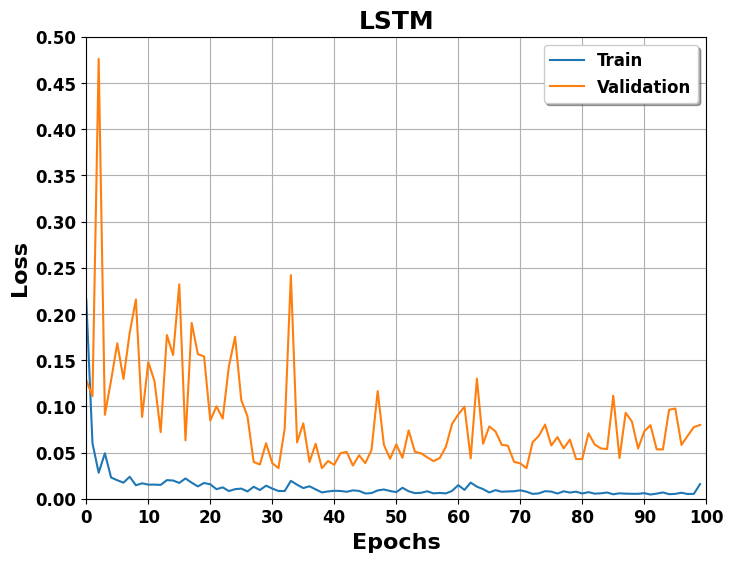

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_1, loader_val_1)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.07 RMSE
Test Score: 0.18 RMSE
Train Score: 0.06 MAE
Test Score: 0.14 MAE


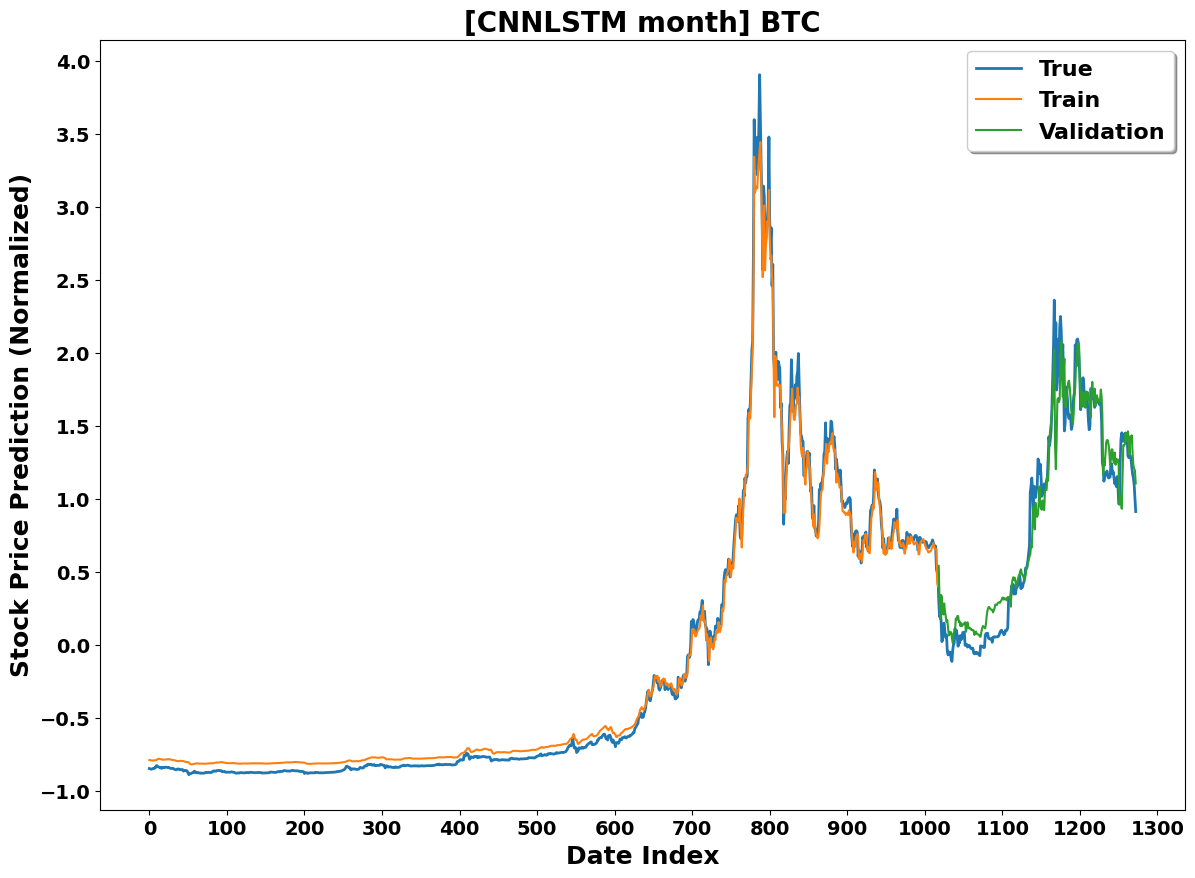

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_1
val_x_data = val_x_month_1
train_y_month = train_y_month_1[:,0]
val_y_month = val_y_month_1[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC', fig_size=(14, 10), save_img=True)

### ***BTC + USD***

In [ ]:
input_dim = train_x_month_2.shape[2] # feature
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.06968257622793317

 best epoch 74: best loss 0.059347066562622786

 best epoch 79: best loss 0.05723843025043607

 best epoch 89: best loss 0.040555014507845044

 best epoch 90: best loss 0.03239538776688278

 best epoch 96: best loss 0.02621970500331372


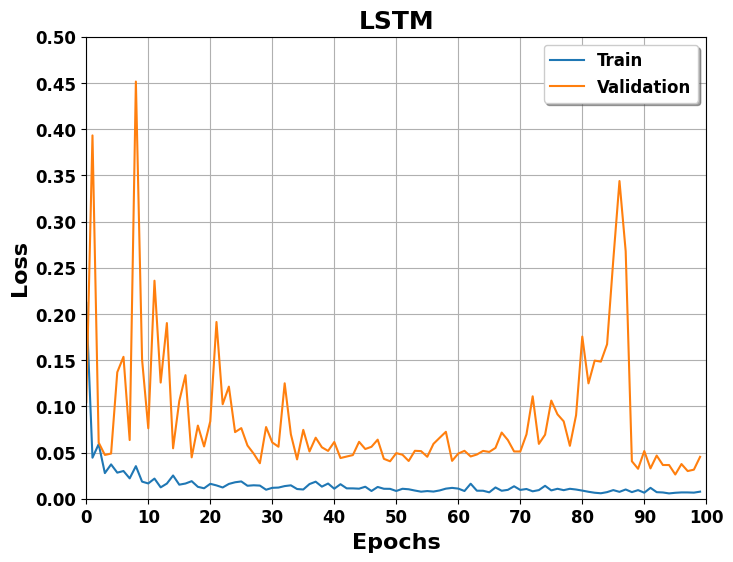

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_2, loader_val_2)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.06 RMSE
Test Score: 0.16 RMSE
Train Score: 0.04 MAE
Test Score: 0.12 MAE


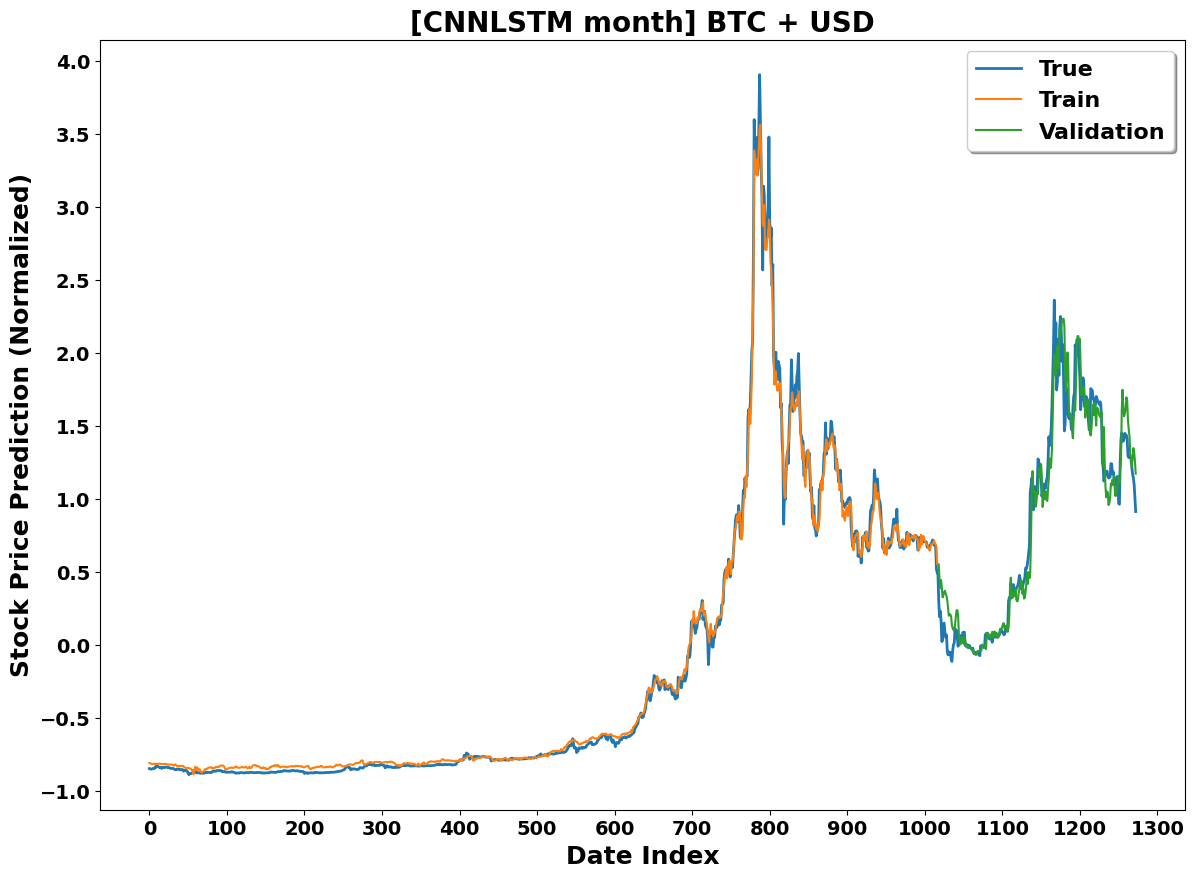

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_2
val_x_data = val_x_month_2
train_y_month = train_y_month_2[:,0]
val_y_month = val_y_month_2[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + USD', fig_size=(14, 10), save_img=True)

### ***BTC + Sentiment***

In [ ]:
input_dim = train_x_month_3.shape[2] # feature
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.021464623627252877


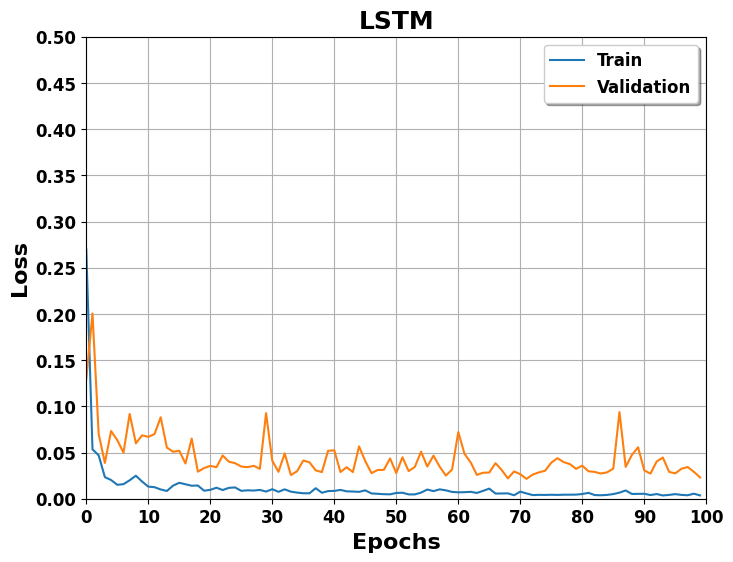

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_3, loader_val_3)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.04 RMSE
Test Score: 0.15 RMSE
Train Score: 0.03 MAE
Test Score: 0.11 MAE


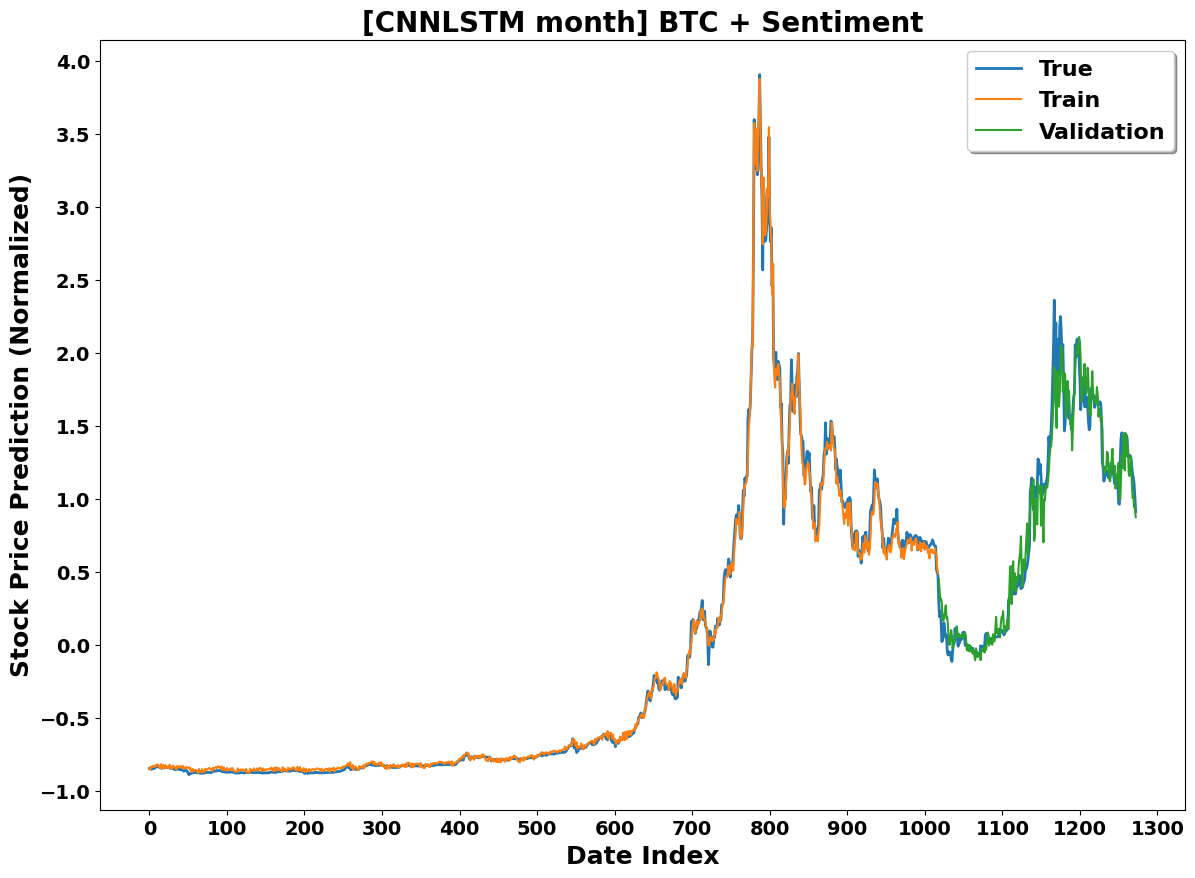

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_3
val_x_data = val_x_month_3
train_y_month = train_y_month_3[:,0]
val_y_month = val_y_month_3[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + Sentiment', fig_size=(14, 10), save_img=True)

### ***BTC + USD + Sentiment***

In [ ]:
input_dim = train_x_month_4.shape[2] # feature
print('feature dim:', input_dim)
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

feature dim: 13


  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.08816110854968429

 best epoch 76: best loss 0.03815173450857401

 best epoch 96: best loss 0.01995622494723648


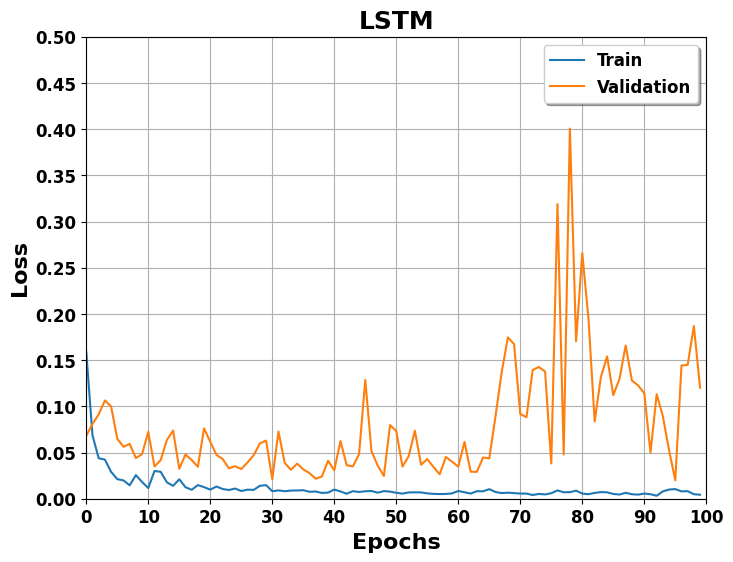

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_4, loader_val_4)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.08 RMSE
Test Score: 0.14 RMSE
Train Score: 0.07 MAE
Test Score: 0.11 MAE


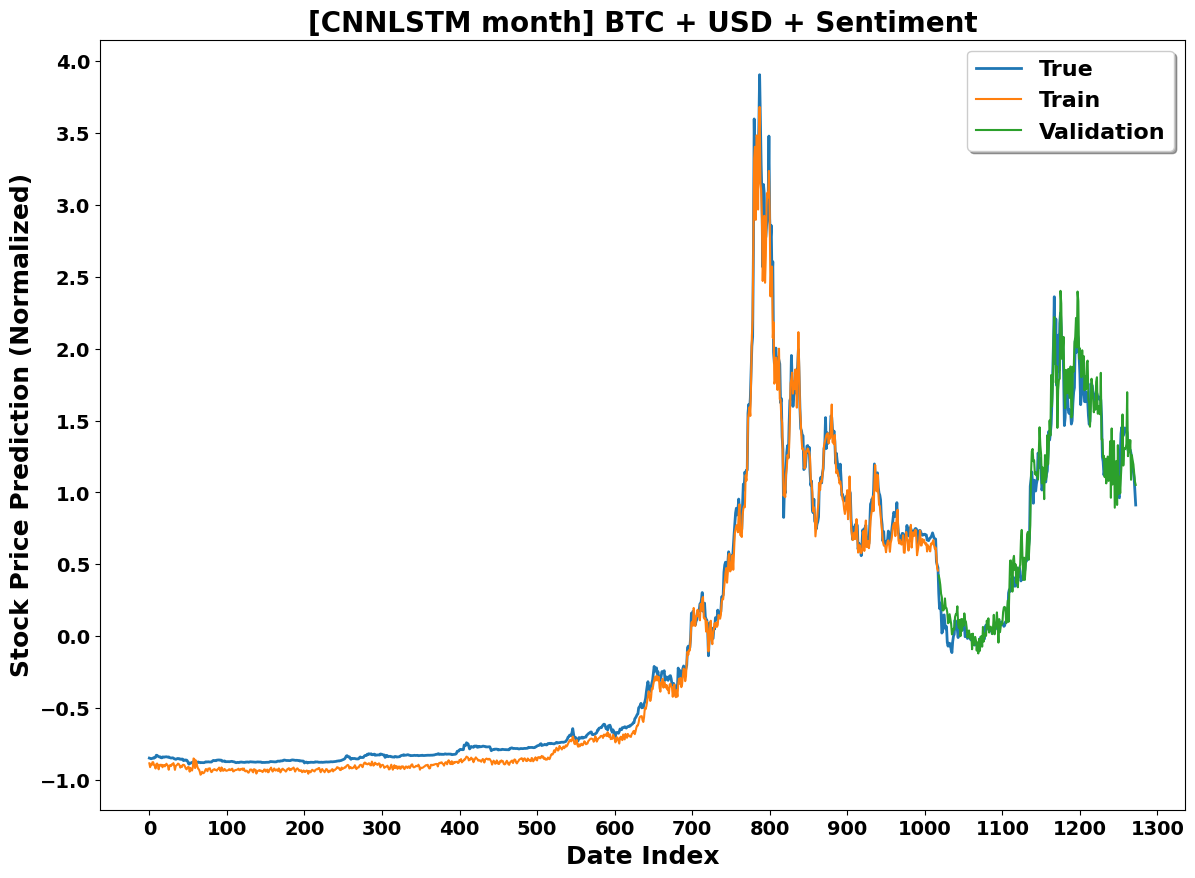

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_4
val_x_data = val_x_month_4
train_y_month = train_y_month_4[:,0]
val_y_month = val_y_month_4[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + USD + Sentiment', fig_size=(14, 10), save_img=True)

### ***BTC + SP500***

In [ ]:
input_dim = train_x_month_5.shape[2] # feature
print('feature dim:', input_dim)
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)

feature dim: 12


  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.08125848323106766

 best epoch 73: best loss 0.07542417803779244

 best epoch 82: best loss 0.050449881702661514

 best epoch 97: best loss 0.041100177681073546


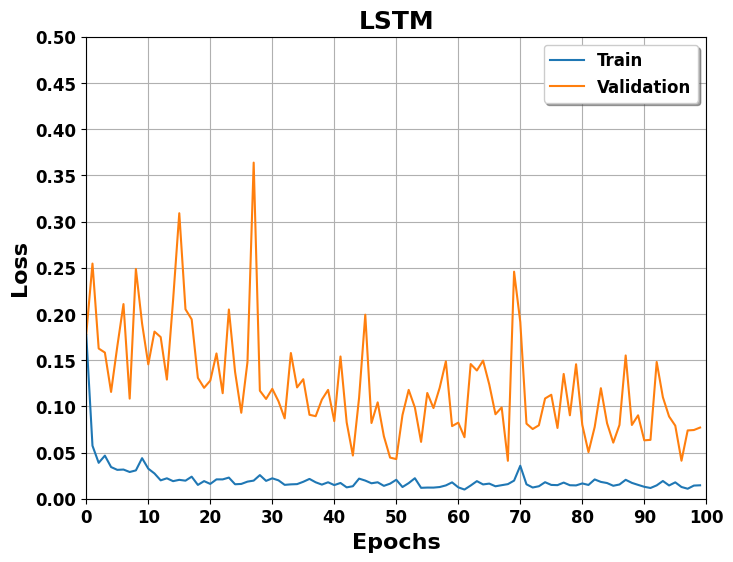

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_5, loader_val_5)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.08 RMSE
Test Score: 0.20 RMSE
Train Score: 0.06 MAE
Test Score: 0.17 MAE


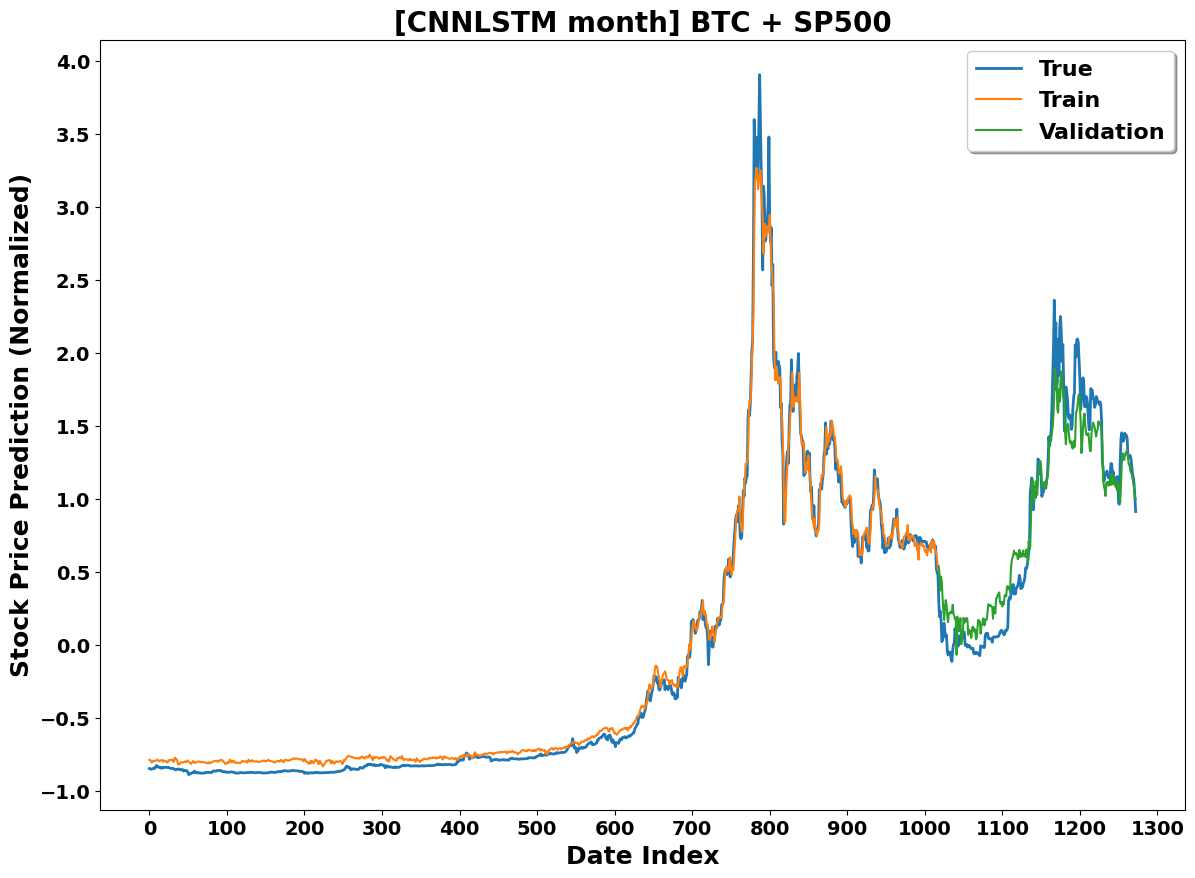

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_5
val_x_data = val_x_month_5
train_y_month = train_y_month_5[:,0]
val_y_month = val_y_month_5[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + SP500', fig_size=(14, 10), save_img=True)

### ***BTC + USD + SP500***

In [ ]:
input_dim = train_x_month_6.shape[2] # feature
print('feature dim:', input_dim)
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.0007)

feature dim: 18


  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.08583723101764917

 best epoch 74: best loss 0.07202396169304848

 best epoch 76: best loss 0.06621604086831212

 best epoch 94: best loss 0.04457991849631071


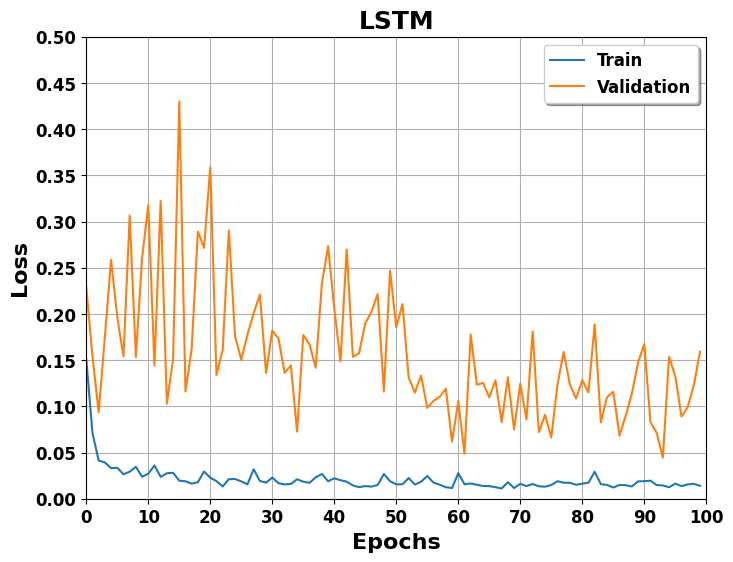

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_6, loader_val_6)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.07 RMSE
Test Score: 0.21 RMSE
Train Score: 0.04 MAE
Test Score: 0.17 MAE


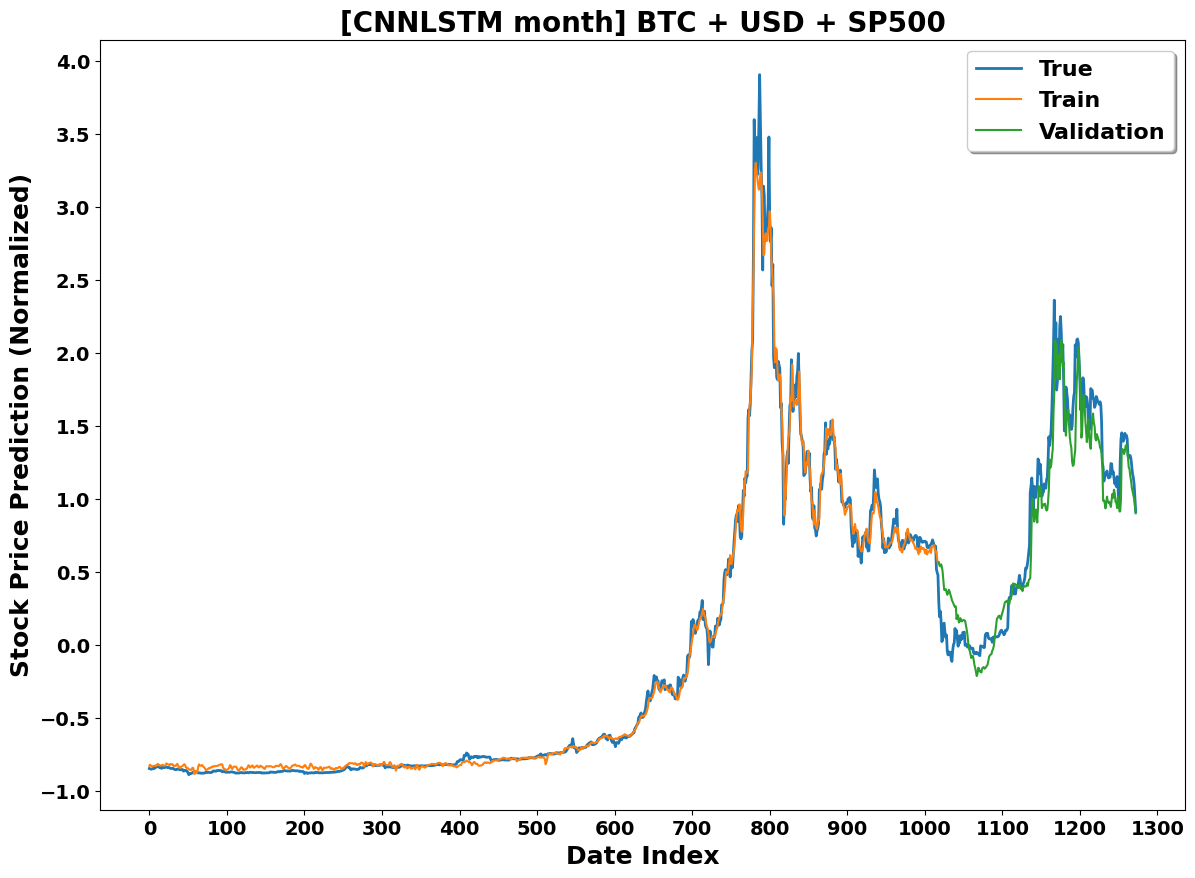

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_6
val_x_data = val_x_month_6
train_y_month = train_y_month_6[:,0]
val_y_month = val_y_month_6[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + USD + SP500', fig_size=(14, 10), save_img=True)

### ***BTC + Sentiment + SP500***

In [ ]:
input_dim = train_x_month_7.shape[2] # feature
print('feature dim:', input_dim)
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)

feature dim: 13


  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.05676565319299698

 best epoch 76: best loss 0.04601787985302508

 best epoch 79: best loss 0.03738830075599253

 best epoch 88: best loss 0.03409200790338218

 best epoch 95: best loss 0.03286223439499736


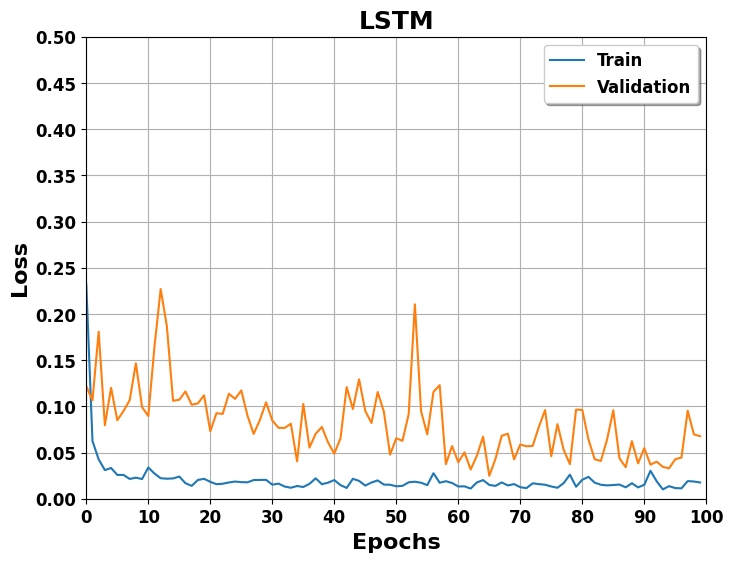

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_7, loader_val_7)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.08 RMSE
Test Score: 0.18 RMSE
Train Score: 0.06 MAE
Test Score: 0.15 MAE


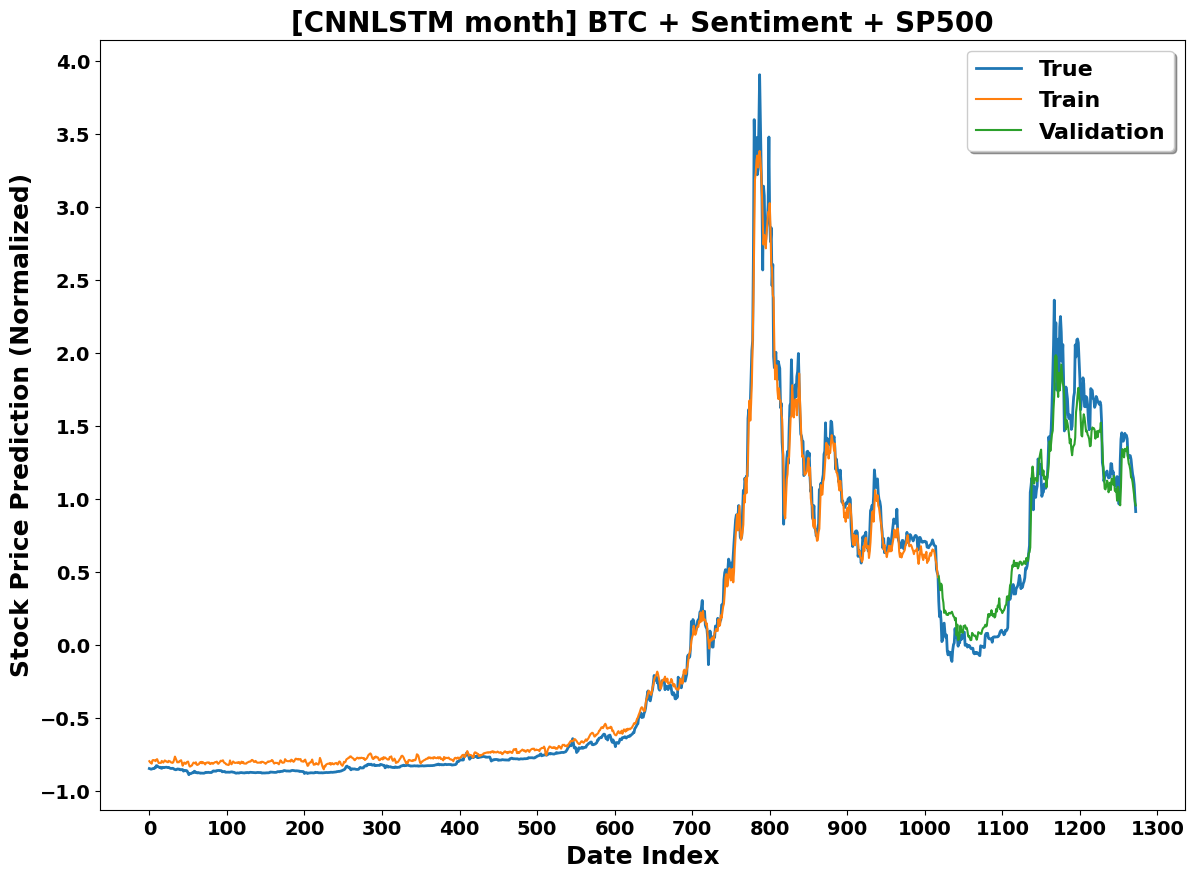

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_7
val_x_data = val_x_month_7
train_y_month = train_y_month_7[:,0]
val_y_month = val_y_month_7[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + Sentiment + SP500', fig_size=(14, 10), save_img=True)

### ***BTC + USD + Sentiment + SP500***

In [ ]:
input_dim = train_x_month_8.shape[2] # feature
print('feature dim:', input_dim)
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout = 0.2
NUM_EPOCHS = 100

lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)

feature dim: 19


  0%|          | 0/100 [00:00<?, ?it/s]


 best epoch 72: best loss 0.14973060600459576

 best epoch 74: best loss 0.12543265707790852

 best epoch 75: best loss 0.1035072086378932

 best epoch 92: best loss 0.0694534070789814

 best epoch 93: best loss 0.059300342574715614

 best epoch 95: best loss 0.05534705286845565

 best epoch 98: best loss 0.035638425732031465


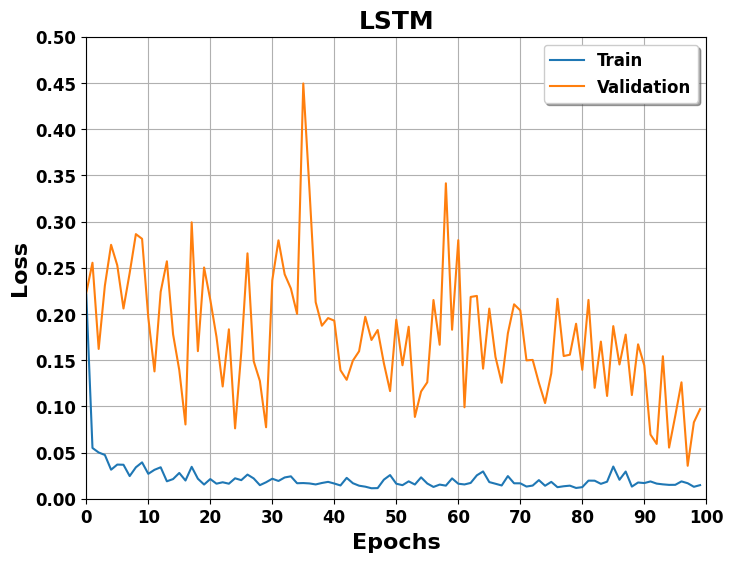

In [ ]:
lstm, loss_train_list, loss_val_list = train_val(lstm, criterion, optimizer, NUM_EPOCHS,
                                                 loader_train_8, loader_val_8)

plot_train_curve(NUM_EPOCHS, loss_train_list, loss_val_list,
                 curve_type='Loss', title='LSTM', fig_size=(8, 6), save_img=True)

Train Score: 0.09 RMSE
Test Score: 0.19 RMSE
Train Score: 0.05 MAE
Test Score: 0.15 MAE


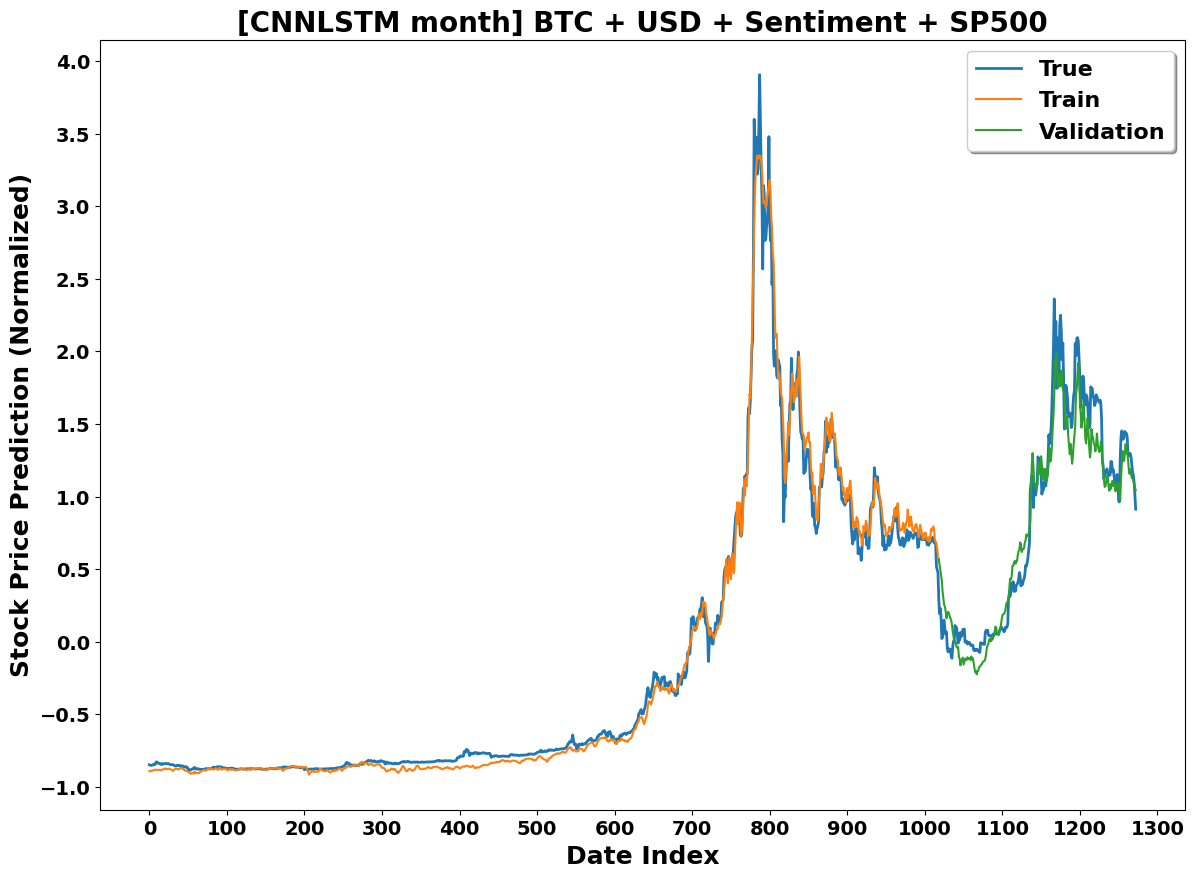

In [ ]:
lstm = torch.load('best_model_cnnlstm_month.pkl')
lstm.eval()
train_x_data = train_x_month_8
val_x_data = val_x_month_8
train_y_month = train_y_month_8[:,0]
val_y_month = val_y_month_8[:,0]

train_month_predict = lstm(train_x_data).detach().numpy()
val_month_predict = lstm(val_x_data).detach().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y_month, train_month_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valscore = math.sqrt(mean_squared_error(val_y_month, val_month_predict[:,0]))
print('Test Score: %.2f RMSE' % (valscore))

trainScore = mean_absolute_error(train_y_month, train_month_predict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
valscore = mean_absolute_error(val_y_month, val_month_predict[:,0])
print('Test Score: %.2f MAE' % (valscore))

# Plot Train and Val price with true price
plot_stock_curve(train_month_predict, val_month_predict, y_month_label, '[CNNLSTM month] BTC + USD + Sentiment + SP500', fig_size=(14, 10), save_img=True)